# Imports

In [1]:
import requests
import json
import math

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pmdarima.arima import auto_arima
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
# import plotly.graph_objects as go

from IPython.display import display
from tqdm import tqdm

import pickle

# Data preprocessing

## Functions

In [2]:
def resample_h(df_in, h):
    r = f'{str(h)}h'
    s = int(96/4/int(h))
    return df_in.resample(r).mean(), s, r

def resample_m(df_in, m):
    r = f'{str(60*m)}min'
    s = int(96/4/m)
    return df_in.resample(r).mean(), s, r

def smooth_ma(df_in, p):
    return df_in.rolling(window=p).mean().bfill()

def df_cuttime(df_in, start_date, amount):
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = start_date_dt + timedelta(days=amount)
    if amount < 0:
        start_date = end_date_dt.strftime('%Y-%m-%d')
        end_date = start_date_dt.strftime('%Y-%m-%d')
    else:
        start_date = start_date_dt.strftime('%Y-%m-%d')
        end_date = end_date_dt.strftime('%Y-%m-%d')
    df_new = df_in[start_date:end_date]
    print(f"{df_new.iloc[0].name.strftime('%Y-%m-%d %H:%M')} - {df_new.iloc[-1].name.strftime('%Y-%m-%d %H:%M')}")
    return df_new

def plot_pred(df_pred, df_f_in):
    plt.figure(figsize=(20,8))
    sns.lineplot(df_f_in.measured, color = 'black', label='Actual')
    sns.lineplot(df_f_in.waf, color='grey', alpha=0.5, label='Their week-ahead forecast')
    sns.lineplot(df_pred[0], color = 'red', label='My forecast')
    plt.legend()
    plt.show()

def plot_input(df_in):
    plt.figure(figsize=(20,8))
    sns.lineplot(df_in.measured, color = 'black', label='Actual')
    plt.show()

def var_stats(df_in):
    cv = df_in.measured.std() / df_in.measured.mean()
    print(f"Coefficient of Variation\t{cv:.3f}")
    iqr = df_in.measured.quantile(0.75) - df_in.measured.quantile(0.25)
    print(f"Interquartile Range (IQR)\t{iqr:.3f}")
    hourly_variation = df_in.measured.resample('h').std()
    print(f"Average Hourly Variation\t{hourly_variation.mean():.3f}")
    daily_variation = df_in.measured.resample('D').std()
    print(f"Average Daily Variation\t\t{daily_variation.mean():.3f}")
    monthly_variation = df_in.measured.resample('ME').std()
    print(f"Average Monthly Variation\t{monthly_variation.mean():.3f}")

def forecast_stats(df_in):
    df_in.errordf_in.measured - df_in.waf
    print(f'Mean\t\t{round(df_in.waf.mean(),2)}')
    print(f'Median\t\t{round(df_in.waf.median(),2)}')
    print(f'Mode\t\t{round(df_in.waf.mode()[0],2)}')
    print(f'Std Dev\t\t{round(df_in.waf.std(),2)}')
    print(f'Mean Error\t{round(df_in.error.mean(),2)}')
    print(f'Median Error\t{round(df_in.error.median(),2)}')
    print(f'Mode Error\t{round(df_in.error.mode()[0],2)}')
    print(f'Error Std Dev\t{round(df_in.error.std(),2)}')
    print(f'Max Error\t{round(abs(df_in.error).max(),2)}')
    print(f'MAE\t\t{round(mean_absolute_error(df_in.measured, df_in.waf),2)}')
    print(f'MSE\t\t{round(mean_squared_error(df_in.measured, df_in.waf),2)}')
    print(f'RMSE\t\t{round(np.sqrt(mean_squared_error(df_in.measured, df_in.waf)),2)}')
    mape = np.where(df_in.measured != 0, np.abs(df_in.error / df_in.measured) * 100, 0)
    print(f'MA%E\t\t{round(np.mean(mape), 2)}')
    print(f'R²\t\t{round(r2_score(df_in.measured, df_in.waf),2)}')

def jgstats(df_in_pred, df_in_f):
    df_in = pd.concat([df_in_f, df_in_pred], axis=1)
    df_in = df_in.bfill().ffill()
    df_in = df_in.drop(['waf'], axis=1)
    df_in = df_in.rename(columns={0:'prediction'})
    df_in.error = df_in.measured - df_in.prediction
    print(f'Mean\t\t{round(df_in.prediction.mean(),2)}')
    print(f'Median\t\t{round(df_in.prediction.median(),2)}')
    print(f'Mode\t\t{round(df_in.prediction.mode()[0],2)}')
    print(f'Std Dev\t\t{round(df_in.prediction.std(),2)}')
    print(f'Mean Error\t{round(df_in.error.mean(),2)}')
    print(f'Median Error\t{round(df_in.error.median(),2)}')
    print(f'Mode Error\t{round(df_in.error.mode()[0],2)}')
    print(f'Error Std Dev\t{round(df_in.error.std(),2)}')
    print(f'Max Error\t{round(abs(df_in.error).max(),2)}')
    print(f'MAE\t\t{round(mean_absolute_error(df_in.measured, df_in.prediction),2)}')
    print(f'MSE\t\t{round(mean_squared_error(df_in.measured, df_in.prediction),2)}')
    print(f'RMSE\t\t{round(np.sqrt(mean_squared_error(df_in.measured, df_in.prediction)),2)}')
    mape = np.where(df_in.measured != 0, np.abs(df_in.error / df_in.measured) * 100, 0)
    print(f'MA%E\t\t{round(np.mean(mape), 2)}')
    print(f'R²\t\t{round(r2_score(df_in.measured, df_in.prediction),2)}')

## Importing the data

### From a file

In [3]:
raw_data = pd.read_csv('ods032.csv', delimiter=';')

In [57]:
df = raw_data.copy()
df = df.rename(columns={'Measured & Upscaled':'measured'})

### From the API

In [5]:
# df = pd.DataFrame()

# regions = ['Wallonia', 'West-Flanders', 'Flanders', 'Antwerp', 'Belgium', 'Walloon-Brabant', 'Brussels', 'Limburg', 'Liège', 'Luxembourg', 'Namur', 'East-Flanders', 'Flemish-Brabant', 'Hainaut']
# n_years = 1
# n_months = 1
# n_days = 31
# total_iterations = len(regions) * n_years * n_months * n_days

# with tqdm(total=total_iterations, desc='Fetching data') as pbar:
#     for region in regions:
#         year = 2023
#         for month in range(1, n_months+1):
#             for day in range(1, n_days+1):
#                 url = f'https://opendata.elia.be/api/explore/v2.1/catalog/datasets/ods032/records?limit=100&refine=region%3A%22{region}%22&refine=datetime%3A{year}-{month:02d}-{day:02d}'
#                 r = requests.get(url)
#                 if r.status_code == 200:
#                     temp_df = pd.DataFrame(r.json()['results'])
#                     df = pd.concat([df, temp_df], ignore_index=True)
#                 else:
#                     print(f'{day}/{month}/{year}: {r.status_code}')
#                 pbar.update(1)

# df.datetime = pd.to_datetime(df.datetime, utc=True)
# df.datetime = df.datetime.dt.tz_localize(None)

## Preprocessing

In [58]:
df = df.rename(columns={'Datetime':'datetime',
                        'Region':'region',
                        'Most recent forecast':'mostrecentforecast',
                        'Week-ahead forecast':'weekaheadforecast'})
df.datetime = pd.to_datetime(df.datetime, utc=True)
df.set_index("datetime", inplace=True)
df = df.sort_index()
df = df.ffill().bfill()

df_be = df[df.region == 'Belgium'].copy()

# display(df)
# display(df.describe())

,Resolution code,region,measured,mostrecentforecast,Most recent P10,Most recent P90,Day Ahead 11AM forecast,Day Ahead 11AM P10,Day Ahead 11AM P90,Day-ahead 6PM forecast,Day-ahead 6PM P10,Day-ahead 6PM P90,weekaheadforecast,Week-ahead P10,Week-ahead P90,Monitored capacity,Load factor
datetime,,,,,,,,,,,,,,,,,
2018-09-30 22:00:00+00:00,PT15M,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3369.051,0.0
2018-09-30 22:00:00+00:00,PT15M,Wallonia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,932.621,0.0
2018-09-30 22:00:00+00:00,PT15M,Flemish-Brabant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,282.185,0.0
2018-09-30 22:00:00+00:00,PT15M,Antwerp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,535.194,0.0
2018-09-30 22:00:00+00:00,PT15M,Hainaut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,243.675,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-27 22:45:00+00:00,PT15M,Flanders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7694.338,0.0
2024-10-27 22:45:00+00:00,PT15M,Wallonia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2376.313,0.0
2024-10-27 22:45:00+00:00,PT15M,Brussels,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,325.056,0.0


## Plots

Text(0.5, 1.0, 'All Belgium generation data')

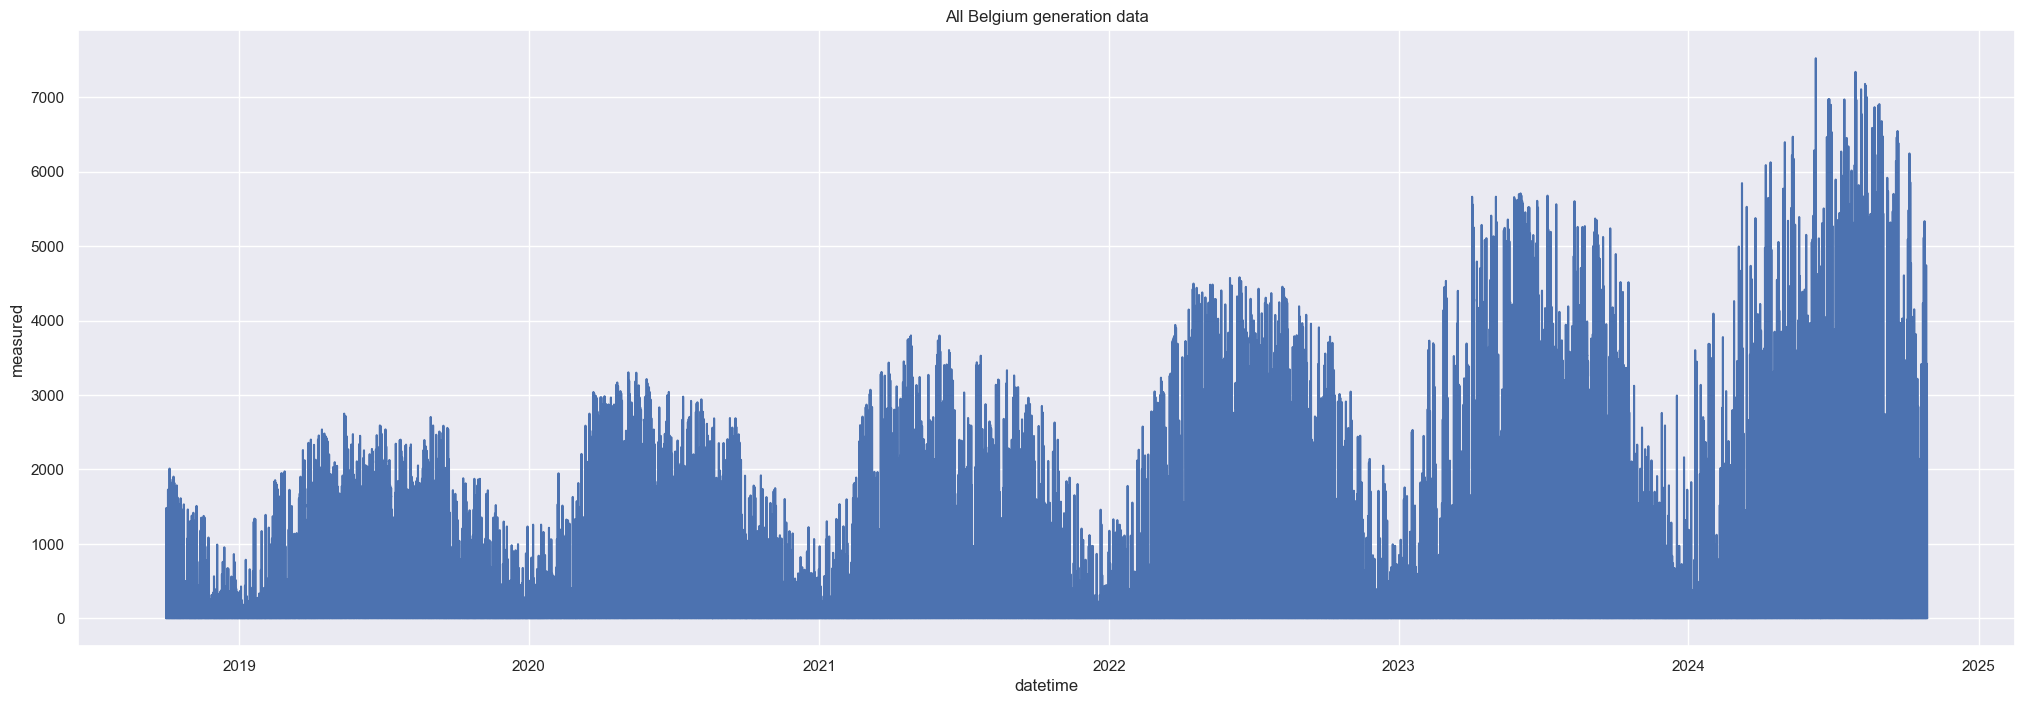

In [8]:
plt.figure(figsize=(25,8))
sns.lineplot(df_be.measured)
plt.title('All Belgium generation data')

## Stats

In [9]:
var_stats(df_be)

Coefficient of Variation	1.715
Interquartile Range (IQR)	898.792
Average Hourly Variation	62.569
Average Daily Variation		802.718
Average Monthly Variation	876.675


## Splitting by value

80-100:	3936
60-80:	14208
40-60:	40700
20-40:	76512
0-20:	77672


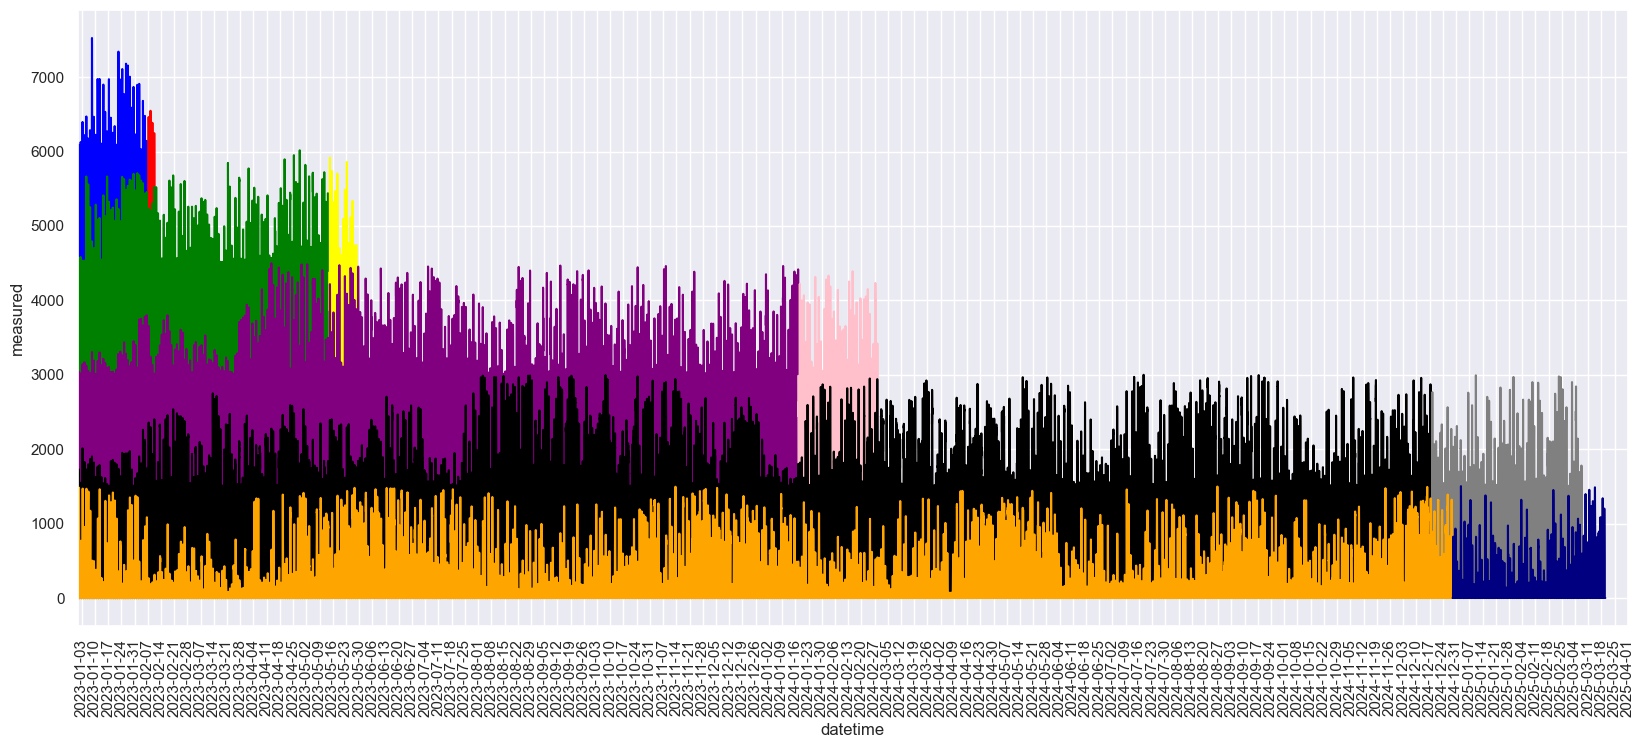

In [61]:
daily_max = df_be.measured.resample('D').max()
total_max = daily_max.max()

pc_80_100 = daily_max[daily_max >= total_max*0.8].index
pc_60_80 = daily_max[(daily_max >= total_max*0.6) & (daily_max < total_max*0.8)].index
pc_40_60 = daily_max[(daily_max >= total_max*0.4) & (daily_max < total_max*0.6)].index
pc_20_40 = daily_max[(daily_max >= total_max*0.2) & (daily_max < total_max*0.4)].index
pc_0_20 = daily_max[(daily_max < total_max*0.2)].index

df_pc_80_100 = df_be[df_be.index.normalize().isin(pc_80_100)]
df_pc_80_100 = df_pc_80_100.reset_index(drop=True)
df_pc_80_100['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_80_100), freq="15min")
df_pc_80_100.set_index('datetime', inplace=True)
print(f'80-100:\t{len(df_pc_80_100)}')
split_pc_80_100 = math.floor(len(df_pc_80_100)*0.9)
df_pc_80_100_past = df_pc_80_100.iloc[:split_pc_80_100]
df_pc_80_100_future = df_pc_80_100.iloc[split_pc_80_100:]

df_pc_60_80 = df_be[df_be.index.normalize().isin(pc_60_80)]
df_pc_60_80 = df_pc_60_80.reset_index(drop=True)
df_pc_60_80['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_60_80), freq="15min")
df_pc_60_80.set_index('datetime', inplace=True)
print(f'60-80:\t{len(df_pc_60_80)}')
split_pc_60_80 = math.floor(len(df_pc_60_80)*0.9)
df_pc_60_80_past = df_pc_60_80.iloc[:split_pc_60_80]
df_pc_60_80_future = df_pc_60_80.iloc[split_pc_60_80:]

df_pc_40_60 = df_be[df_be.index.normalize().isin(pc_40_60)]
df_pc_40_60 = df_pc_40_60.reset_index(drop=True)
df_pc_40_60['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_40_60), freq="15min")
df_pc_40_60.set_index('datetime', inplace=True)
print(f'40-60:\t{len(df_pc_40_60)}')
split_pc_40_60 = math.floor(len(df_pc_40_60)*0.9)
df_pc_40_60_past = df_pc_40_60.iloc[:split_pc_40_60]
df_pc_40_60_future = df_pc_40_60.iloc[split_pc_40_60:]

df_pc_20_40 = df_be[df_be.index.normalize().isin(pc_20_40)]
df_pc_20_40 = df_pc_20_40.reset_index(drop=True)
df_pc_20_40['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_20_40), freq="15min")
df_pc_20_40.set_index('datetime', inplace=True)
print(f'20-40:\t{len(df_pc_20_40)}')
split_pc_20_40 = math.floor(len(df_pc_20_40)*0.9)
df_pc_20_40_past = df_pc_20_40.iloc[:split_pc_20_40]
df_pc_20_40_future = df_pc_20_40.iloc[split_pc_20_40:]

df_pc_0_20 = df_be[df_be.index.normalize().isin(pc_0_20)]
df_pc_0_20 = df_pc_0_20.reset_index(drop=True)
df_pc_0_20['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_0_20), freq="15min")
df_pc_0_20.set_index('datetime', inplace=True)
print(f'0-20:\t{len(df_pc_0_20)}')
split_pc_0_20 = math.floor(len(df_pc_0_20)*0.9)
df_pc_0_20_past = df_pc_0_20.iloc[:split_pc_0_20]
df_pc_0_20_future = df_pc_0_20.iloc[split_pc_0_20:]

plt.figure(figsize=(20,8))
sns.lineplot(df_pc_80_100_past.measured, color='blue')
sns.lineplot(df_pc_80_100_future.measured, color='red')
sns.lineplot(df_pc_60_80_past.measured, color='green')
sns.lineplot(df_pc_60_80_future.measured, color='yellow')
sns.lineplot(df_pc_40_60_past.measured, color='purple')
sns.lineplot(df_pc_40_60_future.measured, color='pink')
sns.lineplot(df_pc_20_40_past.measured, color='black')
sns.lineplot(df_pc_20_40_future.measured, color='grey')
sns.lineplot(df_pc_0_20_past.measured, color='orange')
sns.lineplot(df_pc_0_20_future.measured, color='navy')
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2025-04-01'))
plt.show()

80-100:	3840
60-80:	14208
40-60:	40700
20-40:	76512
0-20:	77672


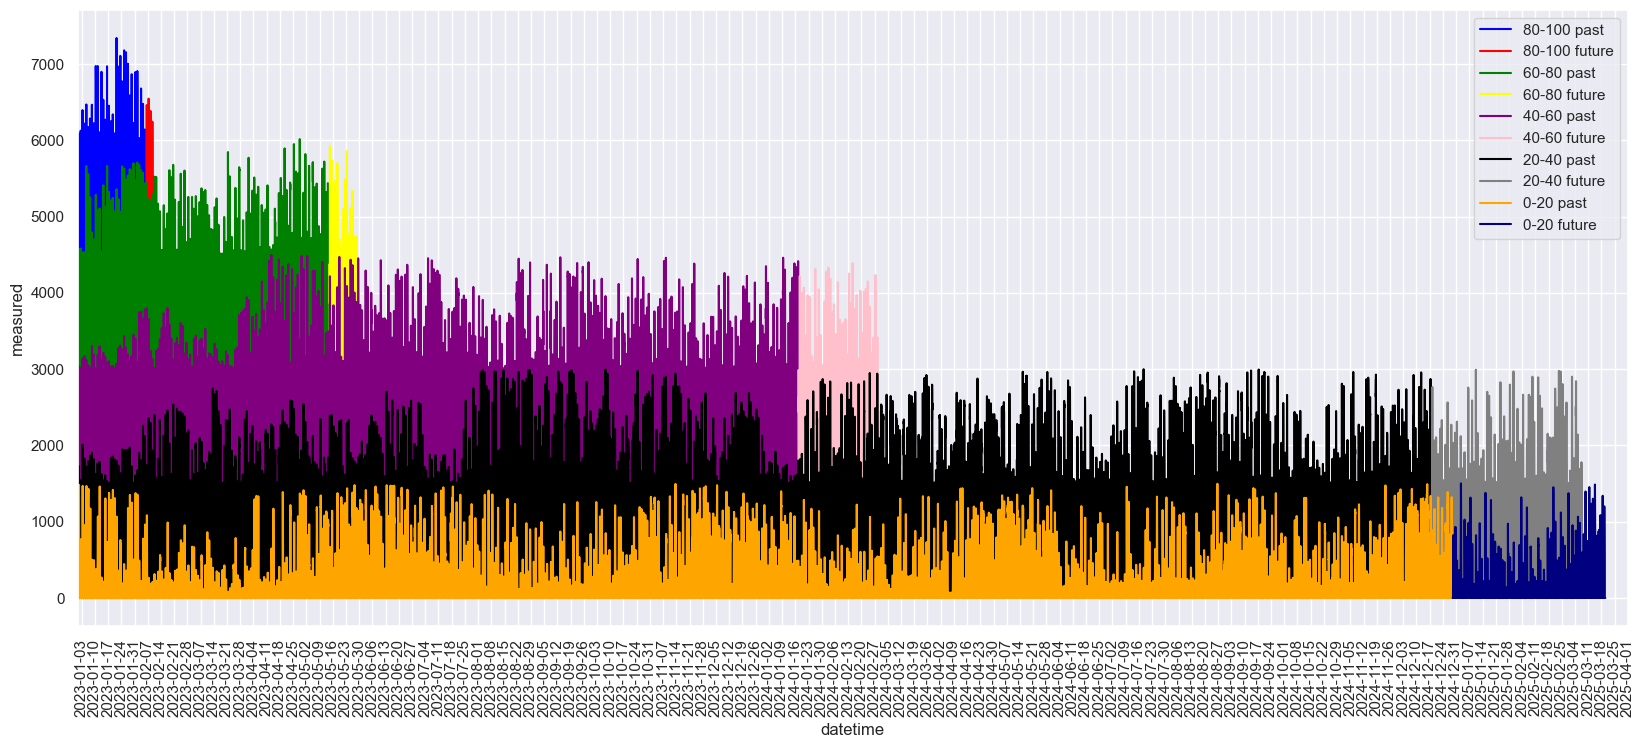

In [11]:
def process_data(df, indices, start_date, freq="15min"):
    df_filtered = df[df.index.normalize().isin(indices)].reset_index(drop=True)
    df_filtered.datetime = pd.date_range(start=start_date, periods=len(df_filtered), freq=freq)
    df_filtered.set_index('datetime', inplace=True)
    split_index = math.floor(len(df_filtered) * 0.9)
    return df_filtered.iloc[:split_index], df_filtered.iloc[split_index:]

daily_max = df_be.measured.resample('D').max()
total_max = daily_max.max()

ranges = {
    '80-100': (0.8, 1.0),
    '60-80': (0.6, 0.8),
    '40-60': (0.4, 0.6),
    '20-40': (0.2, 0.4),
    '0-20': (0.0, 0.2)
}

data_segments = {}
for label, (low, high) in ranges.items():
    indices = daily_max[(daily_max >= total_max * low) & (daily_max < total_max * high)].index
    past, future = process_data(df_be, indices, start_date="2023-01-01")
    data_segments[label] = (past, future)
    print(f'{label}:\t{len(past) + len(future)}')

plt.figure(figsize=(20, 8))
past_colors = ['blue', 'green', 'purple', 'black', 'orange']
future_colors = ['red', 'yellow', 'pink', 'grey', 'navy']

for (label, (past, future)), past_color, future_color in zip(data_segments.items(), past_colors, future_colors):
    sns.lineplot(past.measured, color=past_color, label=f'{label} past')
    sns.lineplot(future.measured, color=future_color, label=f'{label} future')

plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2025-04-01'))
plt.legend()
plt.show()

# Their forecasts

In [12]:
region_max = df.groupby('region').measured.max().sort_values(ascending=False)
plt.figure(figsize=(10, 10))
plt.title('Week ahead forecast vs generation by region')
for region in region_max.index.values:
    ax = sns.regplot(df[df.region==region], y='measured', x='weekaheadforecast', label=region)
plt.legend(loc='upper left')
plt.show()

In [13]:
region_max = df.groupby('region').measured.max().sort_values(ascending=False)
plt.figure(figsize=(10, 10))
plt.title('Most recent forecast vs generation by region')
for region in region_max.index.values:
    ax = sns.regplot(df[df.region==region], y='measured', x='mostrecentforecast', label=region)
plt.legend(loc='upper left')
plt.show()

In [14]:
plt.figure(figsize=(20, 20))
plt.suptitle('Week ahead forecast vs generation by region', fontsize=16)

regions = df.region..unique()
rows, cols = 4, 4

for i, region in enumerate(regions, 1):
    # print(region)
    ax = plt.subplot(rows, cols, i)
    region_data = df[df.region. == region]
    
    max_value = max(
        region_data.weekaheadforecast.max(),
        region_data.measured.max()
    )
    max_limit = np.ceil(max_value)+100
    
    sns.regplot(data=region_data, 
                x='weekaheadforecast', 
                y='measured')
    plt.title(region)
    plt.xlabel('weekaheadforecast')
    plt.ylabel('measured')
    
    ax.set_xlim(0, max_limit)
    ax.set_ylim(0, max_limit)
    
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Forecast errors

In [64]:
df_errs = df[['region','weekaheadforecast','mostrecentforecast','measured']]
df_errs = df_errs[df_errs.measured != 0]
df_errs = df_errs.dropna()

df_errs['forecastweekerror'] = df_errs.measured - df_errs.weekaheadforecast
df_errs['forecastweekpercentageerror'] = np.divide(
    df_errs.forecastweekerror,
    df_errs.measured,
    out=np.zeros_like(df_errs.forecastweekerror),
    where=df_errs.measured != 0
) * 100
df_errs.forecastweekpercentageerror = df_errs.forecastweekpercentageerror.round(1)

df_errs['forecastrecenterror'] = df_errs.measured - df_errs.mostrecentforecast
df_errs['forecastrecentpercentageerror'] = np.divide(
    df_errs.forecastrecenterror,
    df_errs.measured,
    out=np.zeros_like(df_errs.forecastrecenterror),
    where=df_errs.measured != 0
) * 100
df_errs.forecastrecentpercentageerror = df_errs.forecastrecentpercentageerror.round(1)

df_errs = df_errs[['region','measured', 'weekaheadforecast', 'forecastweekerror', 'forecastweekpercentageerror', 'mostrecentforecast', 'forecastrecenterror', 'forecastrecentpercentageerror']]
# df_errs = df_errs.rename(columns={
#     'weekaheadforecast': 'Forecast Week',
#     'mostrecentforecast': 'Forecast Recent',
# })

In [65]:
mean_errors = []

for i, region in enumerate(df_errs.region.unique()):
    region_data = df_errs[df_errs.region == region]
    week_mean = int(abs(region_data.weekaheadforecast).mean())
    week_mean_error = int(abs(region_data.forecastweekerror).mean())
    week_mean_error_pc = int(region_data.forecastweekpercentageerror.mean())
    week_mae = int(mean_absolute_error(region_data.measured, region_data.forecastweekerror))
    recent_mean = int(abs(region_data.forecastrecenterror).mean())
    recent_mean = int(abs(region_data.forecastrecenterror).mean())
    recent_mae = int(mean_absolute_error(region_data.measured, region_data.forecastrecenterror))
    recent_mean_error_pc = int(region_data.forecastrecentpercentageerror.mean())
    mean_errors.append({'region': region, 'Week': week_mean, 'Week Error': week_mean_error, 'Week % Error': week_mean_error_pc, 'Week MAE': week_mae, 'Recent': recent_mean, 'Recent Error': recent_mean, 'Recent % Error': recent_mean_error_pc, 'Recent MAE': recent_mae})

mean_errors_df_errs = pd.DataFrame(mean_errors)
mean_errors_df_errs = mean_errors_df_errs.sort_values(by='Week', ascending=True)
print('Mean absolute forecast values, forecast (period) vs actual generation, all years, by region')
display(mean_errors_df_errs)

Mean absolute forecast values, forecast (period) vs actual generation, all years, by region


,region,Week,Week Error,Week % Error,Week MAE,Recent,Recent Error,Recent % Error,Recent MAE
1,Walloon-Brabant,26,10,-115,26,3,3,-47,27
12,Brussels,27,11,-151,27,3,3,-63,28
2,Luxembourg,29,10,-113,29,4,4,-57,30
4,Namur,39,15,-147,39,5,5,-65,41
13,Hainaut,84,32,-162,84,10,10,-86,88
5,Flemish-Brabant,106,42,-175,106,13,13,-88,111
0,Liège,112,43,-145,112,15,15,-67,118
8,Limburg,142,55,-172,142,19,19,-84,151
11,West-Flanders,192,77,-234,192,29,29,-142,202
6,Antwerp,212,85,-241,212,27,27,-113,224


In [68]:
mean_errors = []

df_errs['year'] = df_errs.index.year
df_errs_filtered = df_errs[(df_errs.year >= 2019) & (df_errs.year <= 2022)]

for year in df_errs_filtered.year.unique():
    year_data = df_errs_filtered[df_errs_filtered.year == year]
    week_mean = int(abs(year_data.weekaheadforecast).mean())
    week_mean_error = int(abs(year_data.forecastweekerror).mean())
    week_mean_error_pc = int(year_data.forecastweekpercentageerror.mean())
    week_mae = int(mean_absolute_error(year_data.measured, year_data.forecastweekerror))
    recent_mean = int(abs(year_data.mostrecentforecast).mean())
    recent_mean_error = int(abs(year_data.forecastrecenterror).mean())
    recent_mean_error_pc = int(year_data.forecastrecentpercentageerror.mean())
    recent_mae = int(mean_absolute_error(year_data.measured, year_data.forecastrecenterror))
    mean_errors.append({
        'Year': year,
        'Week': week_mean,
        'Week Error': week_mean_error,
        'Week % Error': week_mean_error_pc,
        'Week MAE': week_mae,
        'Recent': recent_mean,
        'Recent Error': recent_mean_error,
        'Recent % Error': recent_mean_error_pc,
        'Recent MAE': recent_mae
    })

mean_errors_df_errs = pd.DataFrame(mean_errors)
mean_errors_df_errs = mean_errors_df_errs.melt(id_vars='Year', var_name='Error', value_name='Value')
mean_errors_df_errs = mean_errors_df_errs.pivot(index='Error', columns='Year', values='Value')
mean_errors_df_errs = mean_errors_df_errs.reindex(['Week', 'Week Error', 'Week % Error', 'Week MAE', 'Recent', 'Recent Error', 'Recent % Error', 'Recent MAE'])

print('Mean absolute forecast values, forecast (period) vs actual generation, all regions, by year')
display(mean_errors_df_errs)

Mean absolute forecast values, forecast (period) vs actual generation, all regions, by year


Year,2019,2020,2021,2022
Error,,,,
Week,160,193,195,270
Week Error,55,63,80,102
Week % Error,-150,-151,-141,-115
Week MAE,160,193,195,270
Recent,170,199,216,303
Recent Error,21,23,27,28
Recent % Error,-87,-67,-66,-75
Recent MAE,170,199,216,303


In [72]:
df_errs.forecastweekpercentageerror[df_errs.forecastweekpercentageerror > 0].count()

814719

In [73]:
total_non_zero = df_errs.measured[df_errs.measured != 0].count()
print(f'Total non-zero data\t\t{total_non_zero:,}')
print(f'Week forecast error positive:\t{int((df_errs.forecastweekpercentageerror[df_errs.forecastweekpercentageerror > 0].count())/total_non_zero*100)}%')
print(f'Week forecast error negative:\t{int((df_errs.forecastweekpercentageerror[df_errs.forecastweekpercentageerror < 0].count())/total_non_zero*100)}%')
print(f'Recent forecast error positive:\t{int((df_errs.forecastrecentpercentageerror[df_errs.forecastrecentpercentageerror > 0].count())/total_non_zero*100)}%')
print(f'Recent forecast error negative:\t{int((df_errs.forecastrecentpercentageerror[df_errs.forecastrecentpercentageerror < 0].count())/total_non_zero*100)}%')


Total non-zero data		1,530,969
Week forecast error positive:	53%
Week forecast error negative:	46%
Recent forecast error positive:	46%
Recent forecast error negative:	52%


Median:		72
Std dev:	558
Min:		-486
Max:		631



,measured,weekaheadforecast,forecastweekerror,forecastweekpercentageerror,mostrecentforecast,forecastrecenterror,forecastrecentpercentageerror,year
count,1374510,1374510,1374510,1374510,1374510,1374510,1374510,1374510
mean,118,124,-6,-204,117,1,-105,2021
std,146,178,121,6214,141,36,3407,2
min,0,0,-3713,-3427500,0,-472,-1188925,2018
25%,14,17,-15,-63,15,-7,-22,2020
50%,56,58,0,2,57,-0,-2,2021
75%,169,165,21,29,169,6,12,2023
max,2690,4198,1932,100,631,2066,100,2024


C:\Users\jgibb\AppData\Local\Temp\ipykernel_20736\333904811.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


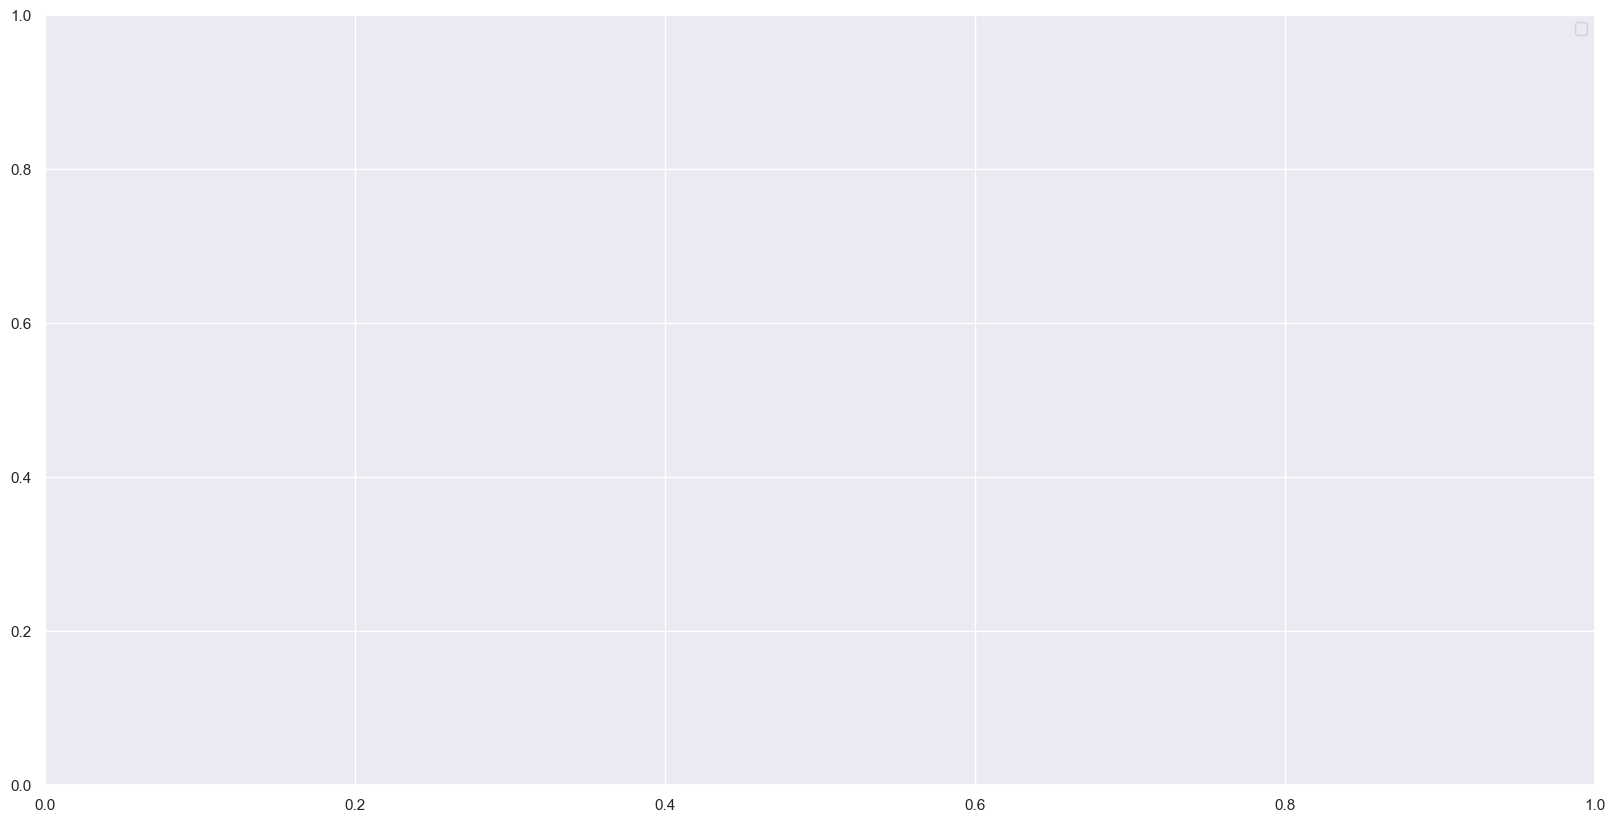

In [69]:
stats_errs = df_errs.mostrecentforecast.agg(['median', 'std'])
print(f"Median:\t\t{int(stats_errs.get('median'))}")
print(f"Std dev:\t{int(stats_errs.get('std'))}")
rpe_min = stats_errs.get('median') - stats_errs.get('std')
print(f"Min:\t\t{int(rpe_min)}")
rpe_max = stats_errs.get('median') + stats_errs.get('std')
print(f"Max:\t\t{int(rpe_max)}")
data_rpe_minmax = df_errs[(df_errs.mostrecentforecast >= rpe_min) & (df_errs.mostrecentforecast <= rpe_max)]
print()
pd.set_option('display.float_format', lambda x: '%.0f' % x)
display(data_rpe_minmax.describe())
pd.reset_option('display.float_format')
print()
plt.figure(figsize=(20,10))
sns.scatterplot(data=data_rpe_minmax, x='datetime', y='forecastrecenterror', label='Recent error')
sns.scatterplot(data=data_rpe_minmax, x='datetime', y='forecastrecentpercentageerror', label='Recent percentage error')
plt.legend(loc='upper right')
# plt.ylim(-2000,2000)

# ARIMA

## Setup

In [22]:
df_be_arima = df_be[['measured','weekaheadforecast']]
df_be_arima = df_be_arima.rename(columns={'weekaheadforecast':'waf'})

## Plots

Text(0.5, 1.0, 'Single Belgian day example')

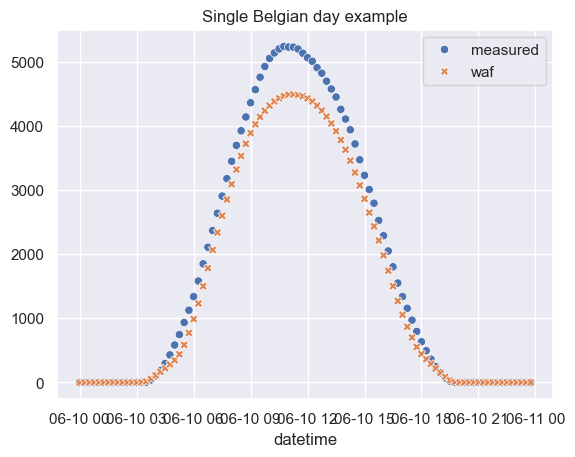

In [23]:
sns.scatterplot(df_be_arima.loc['2023-06-10'])
plt.title('Single Belgian day example')

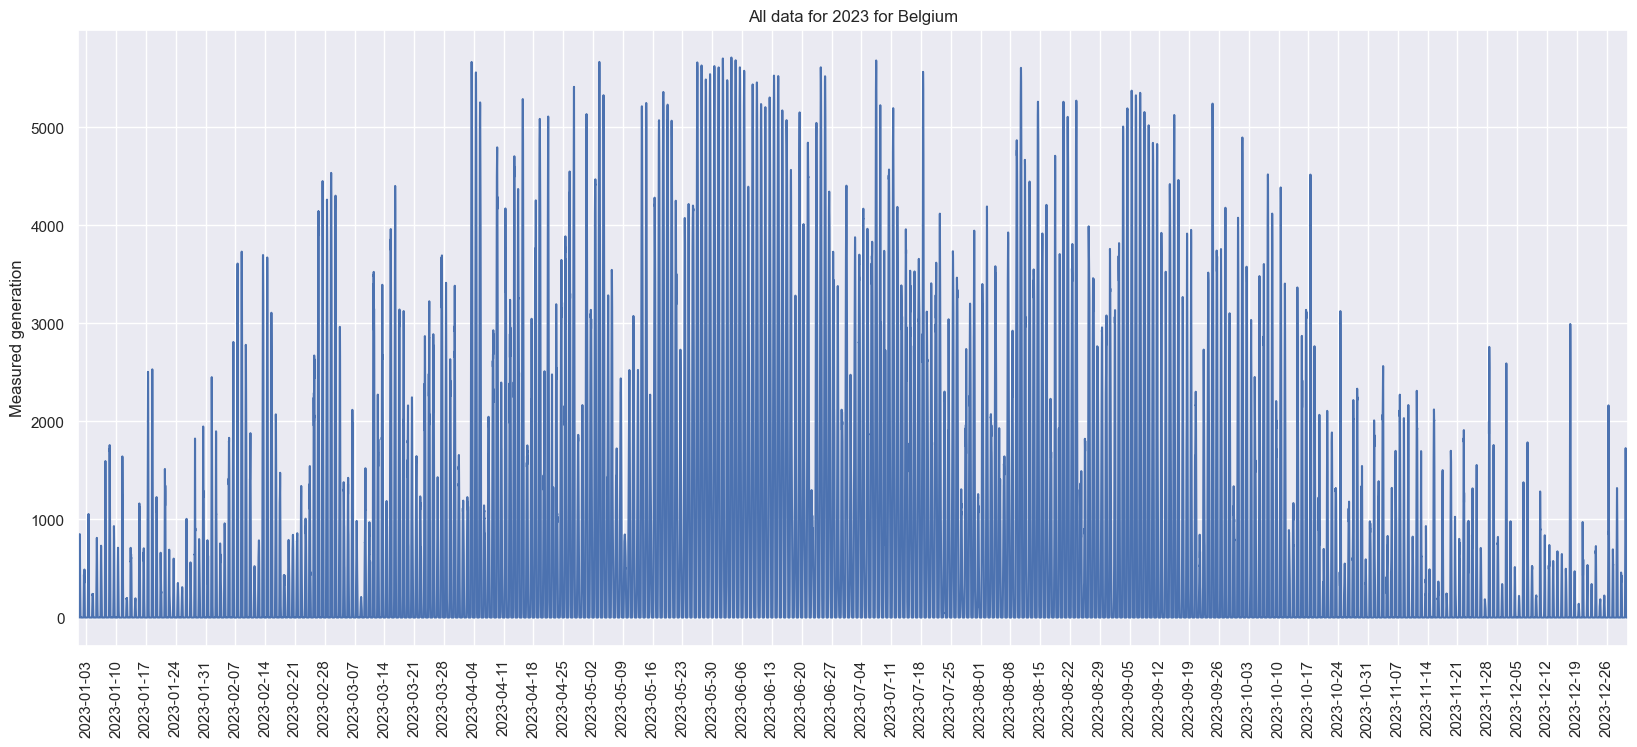

In [24]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be_arima['2023-01-01':'2023-12-31'].measured)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.xlabel('')
plt.ylabel('Measured generation')
plt.title('All data for 2023 for Belgium')
plt.show()

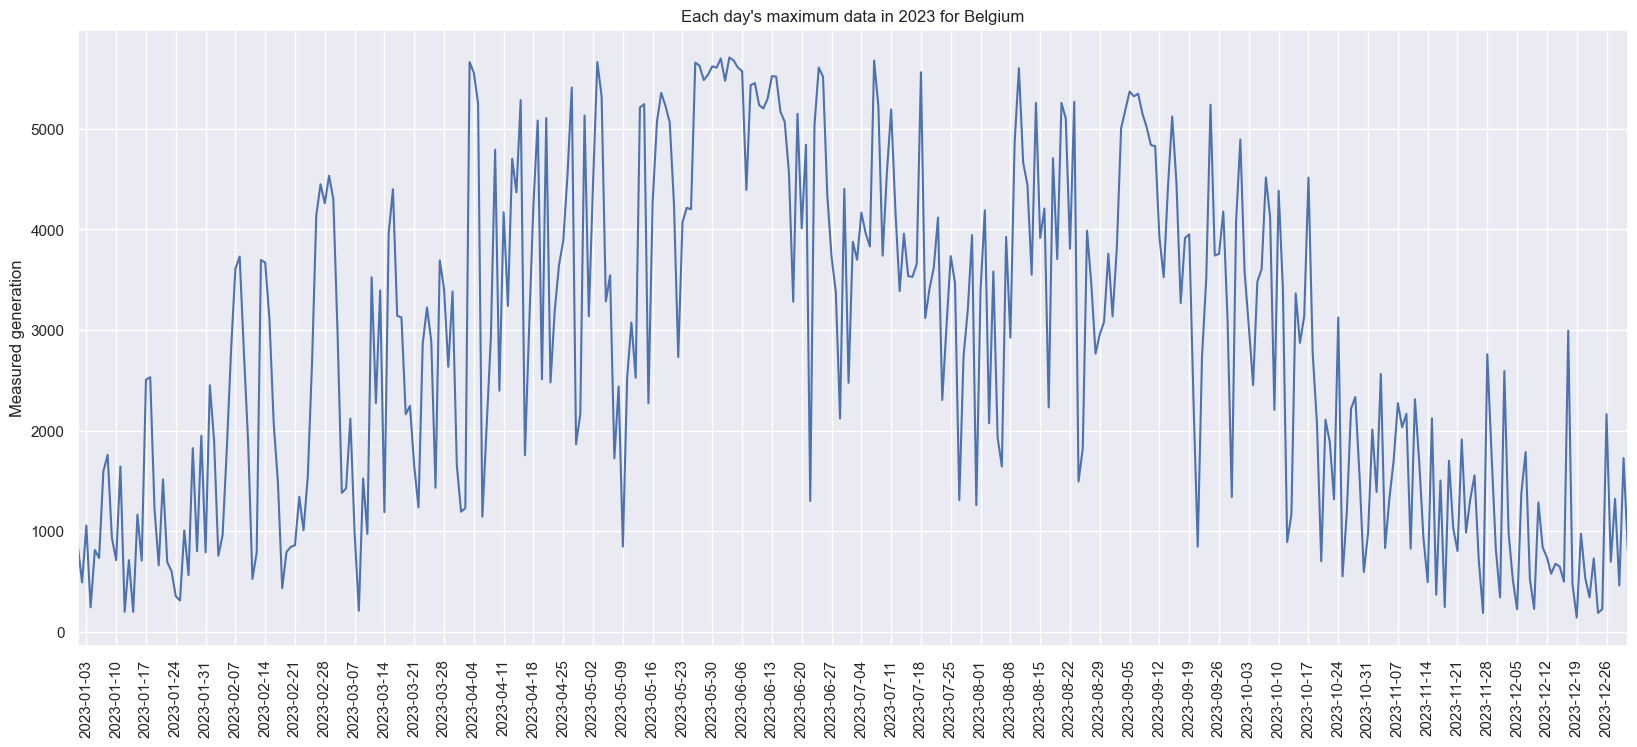

In [25]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be_arima['2023-01-01':'2023-12-31'].measured.resample('D').max())
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.xlabel('')
plt.ylabel('Measured generation')
plt.title("Each day's maximum data in 2023 for Belgium")
plt.show()

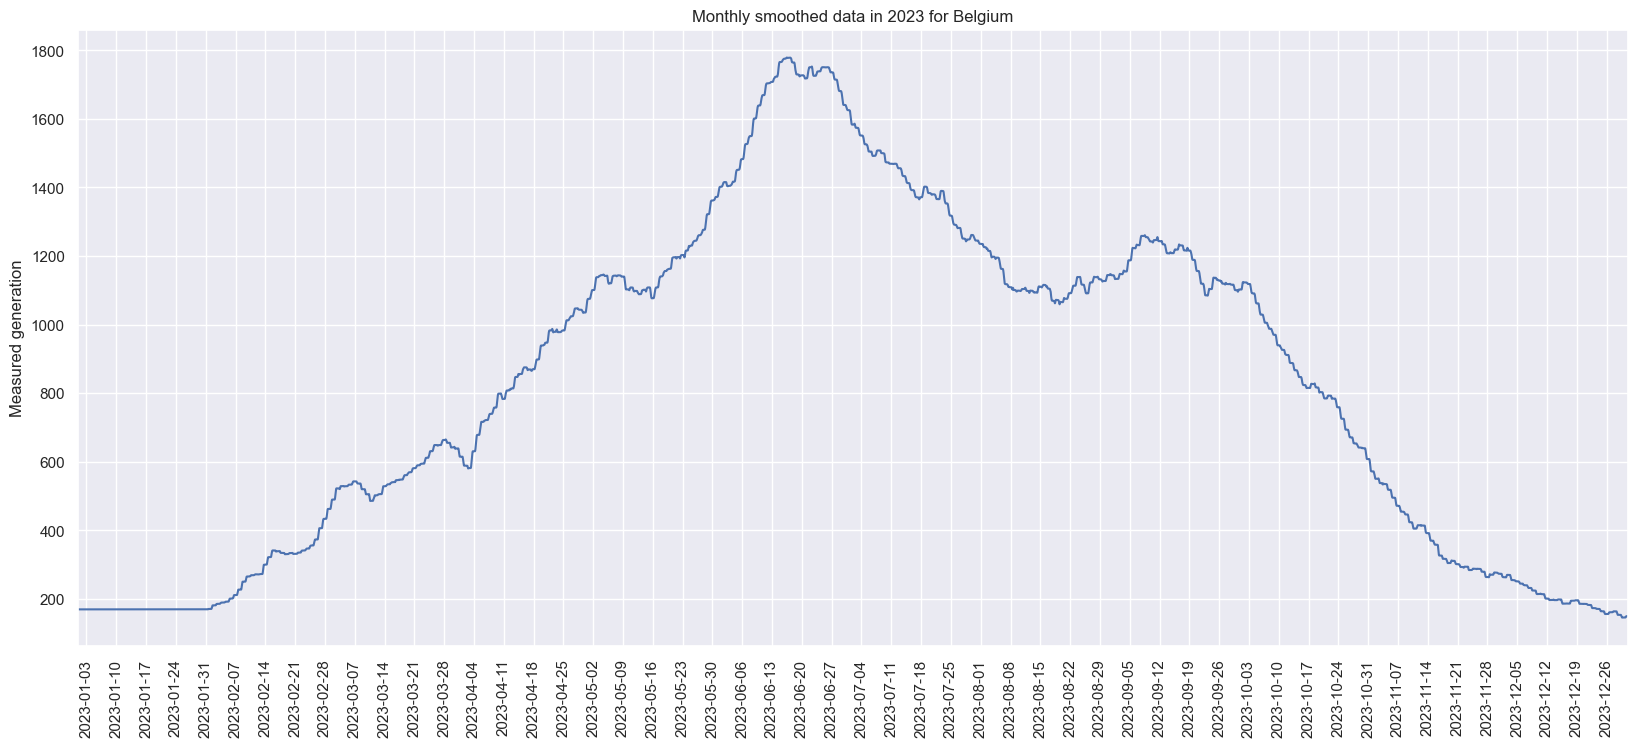

In [26]:
plt.figure(figsize=(20,8))
sns.lineplot(smooth_ma(df_be['2023-01-01':'2023-12-31'].measured,96*30))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.xlabel('')
plt.ylabel('Measured generation')
plt.title("Monthly smoothed data in 2023 for Belgium")
plt.show()

## Modelling

7 days of data, from 2023-05-25 to 2023-05-31
smoothed at 4x, then sampled at 4h, giving 42 values (6/day)
with a seasonal period of 6 (1 days)
with 42 predictons (7 days), until 2023-06-07

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[6] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(0,0,0)(0,1,0)[6] intercept   : AIC=501.561, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[6] intercept   : AIC=496.723, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[6] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[6]             : AIC=501.682, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[6] intercept   : AIC=495.102, Time=0.08 sec
 ARIMA(1,0,0)(0,1,1)[6] intercept   : AIC=496.564, Time=0.10 sec
 ARIMA(1,0,0)(1,1,1)[6] intercept   : AIC=498.558, Time=0.17 sec
 ARIMA(2,0,0)(0,1,0)[6] intercept   : AIC=493.188, Time=0.47 sec
 ARIMA(2,0,0)(1,1,0)[6] intercept   : AIC=495.073, Time=0.67 sec
 ARIMA(2,0,0)(0,1,1)[6] intercept   : AIC=495.014, Time=0.38 sec
 ARIMA(2,0,0)(1,1,1)[6] intercept   : AIC=496.995, Time=0.6

None

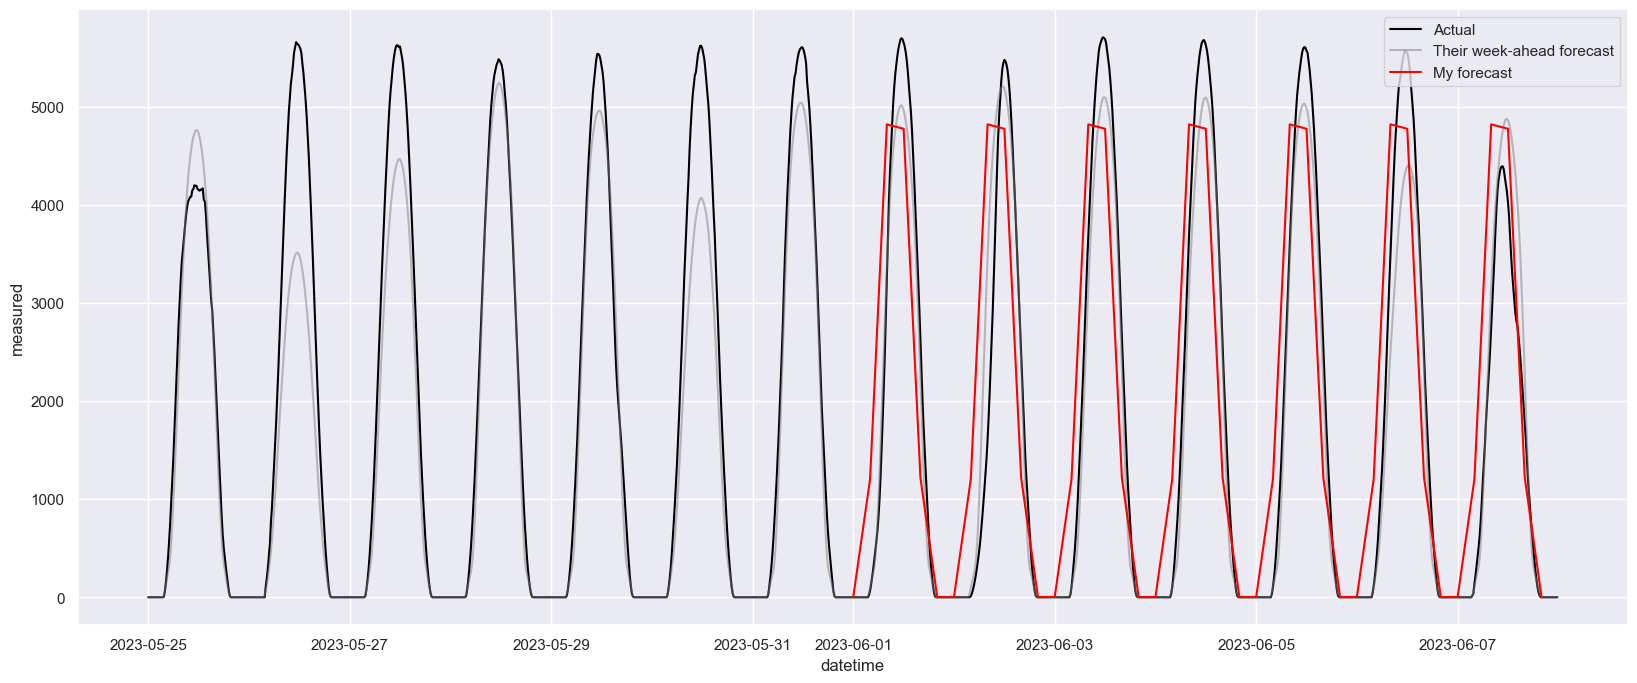

In [27]:
def run_model(df_in=df_be_arima, start='2023-06-01', back=7, pred=7, reduce='both', sa=4, sm=4, m=6, trace=True, stats=True, plot=True, save=False, name=''):
    start_date = pd.to_datetime(start).tz_localize('UTC')
    end_backward = start_date - pd.Timedelta(minutes=15)
    start_backward = end_backward - pd.Timedelta(days=back) + pd.Timedelta(minutes=15)
    end_forward = start_date + pd.Timedelta(days=pred) - pd.Timedelta(minutes=15)
    df_bwd = df_in[start_backward:end_backward]
    df_fwd = df_in[start_date:end_forward]
    df_all = df_in[start_backward:end_forward]

    _ = ''
    if reduce == 'sample':
        if sa > 0 and sa < 1:
            df_run, daily_samples, r = resample_m(df_bwd, sa)
            df_f, _, _ = resample_m(df_fwd, sa)
        else:
            df_run, daily_samples, r = resample_h(df_bwd, sa)
            df_f, _, _ = resample_h(df_fwd, sa)
    elif reduce == 'smooth':
        df_run = smooth_ma(df_bwd, sm)
        df_f = df_fwd
        daily_samples = 96
        r = f'{sm}x'
    elif reduce == 'both':
        # df_run = smooth_ma(df_bwd, sm)
        df_run, daily_samples, r = resample_h(smooth_ma(df_bwd, sm), sa)
        # df_run - smooth_ma(df_fwd, sm)
        df_f, _, _ = resample_h(smooth_ma(df_fwd, sm), sa)
    elif reduce == 'none':
        df_run = df_bwd
        df_f = df_fwd
        daily_samples = 96
        r = 'N/A'
    del _
    
    pred_periods = int(daily_samples*pred)

    if reduce == 'sample':
        print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
    elif reduce == 'smooth':
        print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsmoothed at {r}, with {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
    elif reduce == 'both':
        print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsmoothed at {sm}x, then sampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
    elif reduce == 'none':
        print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')

    # plot_input(df_run)

    if trace:
        model_auto = auto_arima(df_run.measured, seasonal=True, m=int(m), stepwise=True, trace=True)
    else:
        model_auto = auto_arima(df_run.measured, seasonal=True, m=int(m), stepwise=True)
    
    df_auto_pred = pd.DataFrame(model_auto.predict(n_periods=pred_periods))
    df_auto_pred = df_auto_pred.clip(lower=0)
    # df_auto_pred.index = df_auto_pred.index + pd.Timedelta(hours=sa/2) # to centralise samples

    if stats:
        print()
        display(jgstats(df_auto_pred, df_f))

    if plot:
        plot_pred(df_auto_pred, df_all)

    if save:
        with open(f'ods032_model_auto_{name}.pkl', 'wb') as f:
            pickle.dump(model_auto, f)

    return model_auto, df_auto_pred

model_arima, pred_arima = run_model(df_in=df_be_arima, start='2023-06-01', back=7, pred=7, reduce='both', sm=4, sa=4, m=int(96/4/4), trace=True, stats=True, plot=True, save=False, name='')

### Annual

,measured
count,1826.000000
mean,2053.574824
std,1294.042856
min,70.848000
25%,993.549250
50%,1896.203500
75%,2884.340500
max,5709.982000


<Axes: xlabel='datetime'>

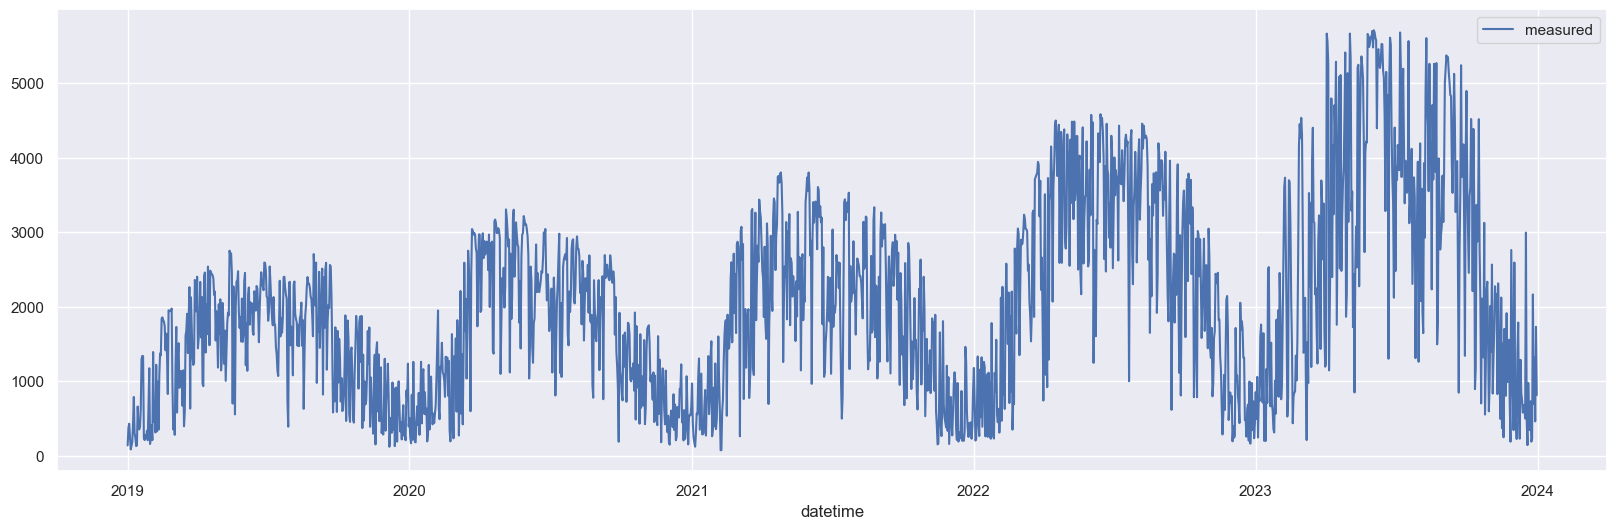

In [28]:
df_be_arima_annual = df_be_arima['2019-01-01':'2023-12-31'].copy()
df_be_arima_annual = df_be_arima_annual.drop('waf', axis=1)
df_be_arima_annual = df_be_arima_annual.resample('D').max()
display(df_be_arima_annual.describe())
plt.figure(figsize=(20,6))
sns.lineplot(df_be_arima_annual)

In [29]:
# daily_samples = 1
# m = 365
# duration_forward = 365
# pred_periods = daily_samples*duration_forward
# df_f = df_forward

# print(f'{int(len(df_be_annual)/daily_samples)} days of data, from {df_be_annual.index[0].date()} to {df_be_annual.index[-1].date()}\ngiving {len(df_be_annual)} values ({daily_samples}/day)\nseasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({duration_forward} days), until {df_f.index[-1].date()}\n')

# plot_input(df_be_annual)

# model_be_annual_auto = auto_arima(df_be_annual.measured, seasonal=True, m=int(m), stepwise=True, trace=True) # jobs=-1
    
# df_be_annual_auto_pred = pd.DataFrame(model_be_annual_auto.predict(n_periods=pred_periods))
# df_be_annual_auto_pred = df_be_annual_auto_pred.clip(lower=0)
# # df_be_annual_auto_pred.index = df_be_annual_auto_pred.index + pd.Timedelta(hours=s/2) # to centralise samples

# print()
# display(jgstats(df_be_annual_auto_pred, df_f))

# plot_pred(df_be_annual_auto_pred)

# with open(f'ods032_model_auto_2019-2023-1D.pkl', 'wb') as f:
#     pickle.dump(model_be_annual_auto, f)

## Model imports and predictions

In [30]:
# model_auto_daily_1h = pickle.load(open('ods032_model_auto_daily_1h.pkl','rb'))
# model_auto_daily_2h = pickle.load(open('ods032_model_auto_daily_2h.pkl','rb'))
# model_auto_daily_4h = pickle.load(open('ods032_model_auto_daily_4h.pkl','rb'))
# model_auto_weekly_1h = pickle.load(open('ods032_model_auto_weekly_1h.pkl','rb'))
# model_auto_weekly_2h = pickle.load(open('ods032_model_auto_weekly_2h.pkl','rb'))
# model_auto_weekly_4h = pickle.load(open('ods032_model_auto_weekly_4h.pkl','rb'))

In [31]:
# df_auto_daily_pred_1h = pd.DataFrame(model_auto_daily_1h.predict(n_periods=24*duration_forward))
# df_auto_daily_pred_1h = df_auto_daily_pred_1h.clip(lower=0)
# df_auto_daily_pred_2h = pd.DataFrame(model_auto_daily_2h.predict(n_periods=12*duration_forward))
# df_auto_daily_pred_2h = df_auto_daily_pred_2h.clip(lower=0)
# df_auto_daily_pred_4h = pd.DataFrame(model_auto_daily_4h.predict(n_periods=6*duration_forward))
# df_auto_daily_pred_4h = df_auto_daily_pred_4h.clip(lower=0)
# df_auto_weekly_pred_1h = pd.DataFrame(model_auto_weekly_1h.predict(n_periods=24*duration_forward))
# df_auto_weekly_pred_1h = df_auto_weekly_pred_1h.clip(lower=0)
# df_auto_weekly_pred_2h = pd.DataFrame(model_auto_weekly_2h.predict(n_periods=12*duration_forward))
# df_auto_weekly_pred_2h = df_auto_weekly_pred_2h.clip(lower=0)
# df_auto_weekly_pred_4h = pd.DataFrame(model_auto_weekly_4h.predict(n_periods=6*duration_forward))
# df_auto_weekly_pred_4h = df_auto_weekly_pred_4h.clip(lower=0)

## Combining models

In [32]:
# # convert all prediction dfs to hourly
# df_auto_daily_pred_2h_temp, _, _ = resample_h(df_auto_daily_pred_2h,1)
# df_auto_daily_pred_2h_temp = df_auto_daily_pred_2h_temp.ffill().bfill()

# # combine with weights
# df_auto_pred_combined = pd.DataFrame(0.5*df_auto_daily_pred_2h_temp + 0.5*df_auto_daily_pred_1h)
# df_auto_pred_combined = df_auto_pred_combined.clip(lower=0)

# plt.figure(figsize=(20,8))
# sns.lineplot(df_forward.measured.iloc[:96*5], color = 'black', label='Actual')
# sns.lineplot(df_forward.waf, color='green', alpha=0.5, label='Their week-ahead forecast')
# sns.lineplot(df_auto_pred_4h[0], color = 'pink', alpha=0.5, label='My 151d forecast, 4h')
# sns.lineplot(df_auto_weekly_pred_4h[0], alpha=0.5, label='My weekly forecast, 4h') # terrible
# sns.lineplot(df_auto_weekly_pred_2h[0], alpha=0.5, label='My weekly forecast, 2h') # terrible
# sns.lineplot(df_auto_weekly_pred_1h[0], alpha=0.5, label='My weekly forecast, 1h') # terrible
# sns.lineplot(df_auto_daily_pred_4h[0], alpha=0.5, label='My daily forecast, 4h')
# sns.lineplot(df_auto_daily_pred_2h[0], alpha=0.5, label='My daily forecast, 2h')
# sns.lineplot(df_auto_daily_pred_1h[0], alpha=0.5, label='My daily forecast, 1h')
# sns.lineplot(df_auto_pred_combined[0].iloc[:120], alpha=0.5, label='My daily forecast, combined')
# plt.legend()
# plt.show()

# result = pd.concat([df_forward.resample('1h').mean().iloc[:120], df_auto_pred_combined.iloc[:120]], axis=1)
# result = result.bfill()
# result = result.ffill()
# result = result.rename(columns={0:'prediction'})
# result['error_mine'] = result.measured - result.prediction
# result['error_waf'] = result.measured - result.waf
# print(f'Mean\t\t{round(result.prediction.mean(),2)}')
# print(f'Median\t\t{round(result.prediction.median(),2)}')
# print(f'Mode\t\t{round(result.prediction.mode()[0],2)}')
# print(f'Std Dev\t\t{round(result.prediction.std(),2)}')
# print(f'Mean Error\t{round(result.error_mine.mean(),2)}')
# print(f'Median Error\t{round(result.error_mine.median(),2)}')
# print(f'Mode Error\t{round(result.error_mine.mode()[0],2)}')
# print(f'Error Std Dev\t{round(result.error_mine.std(),2)}')
# print(f'Max Error\t{round(abs(result.error_mine).max(),2)}')
# print(f'MAE\t\t{round(mean_absolute_error(result.measured, result.prediction),2)}')
# print(f'MSE\t\t{round(mean_squared_error(result.measured, result.prediction),2)}')
# print(f'RMSE\t\t{round(np.sqrt(mean_squared_error(result.measured, result.prediction)),2)}')
# mape = np.where(result.measured != 0, np.abs(result.error_mine / result.measured) * 100, 0)
# print(f'MA%E\t\t{round(np.mean(mape), 2)}')
# print(f'R²\t\t{round(r2_score(result.measured, result.prediction),2)}')

# Keras

## Modelling

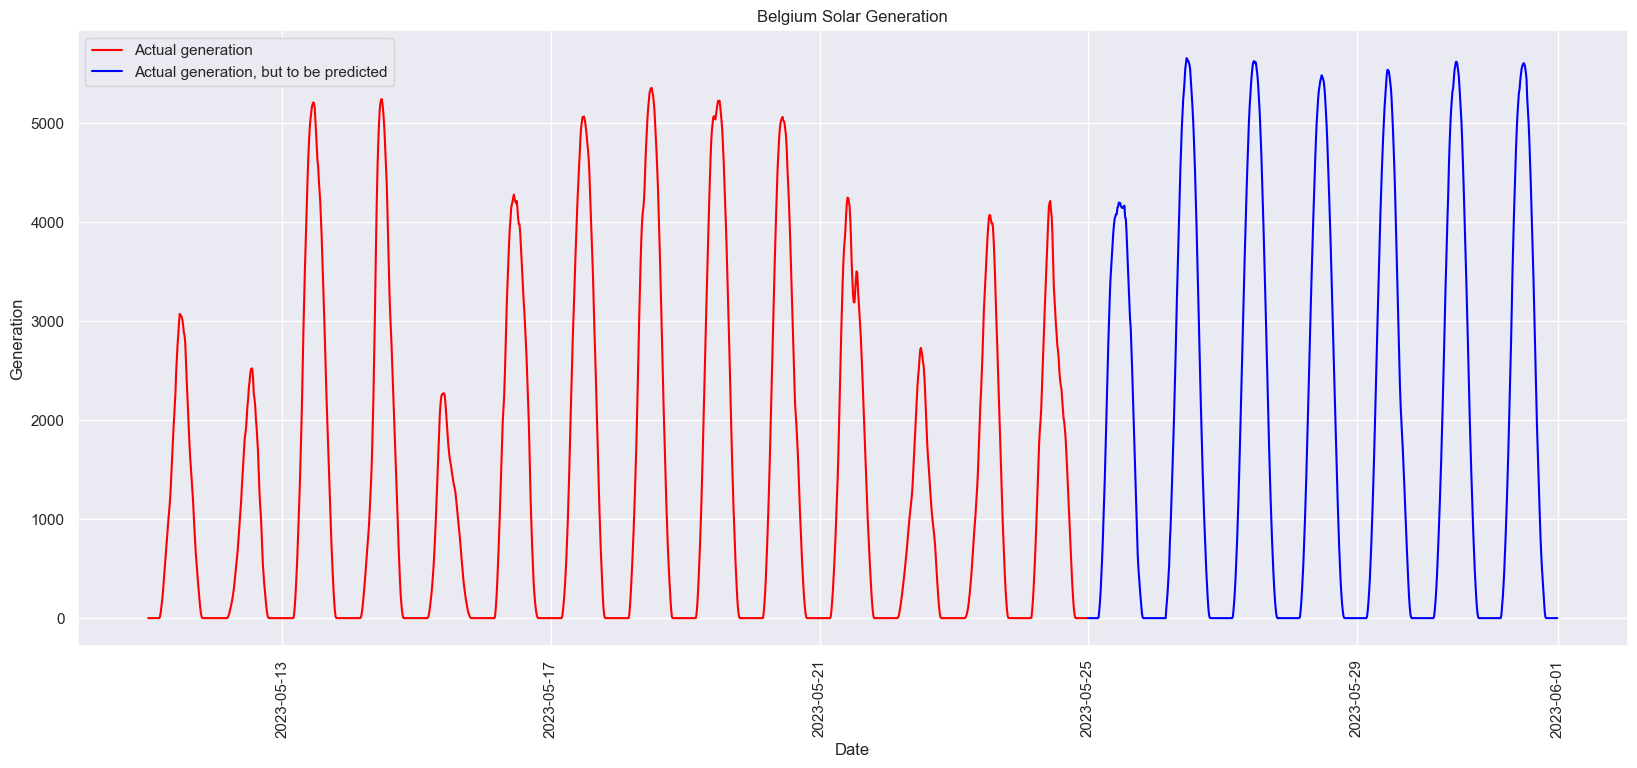

In [33]:
start = '2023-05-25'
back = 14
pred = 7

df_tf = df_be[['measured']].copy()
df_tf['day_of_year'] = df_tf.index.dayofyear / 365.0
df_tf['day_of_year_sin'] = np.sin(2 * np.pi * df_tf.index.dayofyear / 365)
df_tf['day_of_year_cos'] = np.cos(2 * np.pi * df_tf.index.dayofyear / 365)
df_tf['hour_sin'] = np.sin(2 * np.pi * df_tf.index.hour / 24)
df_tf['hour_cos'] = np.cos(2 * np.pi * df_tf.index.hour / 24)
df_tf_prescaled = df_tf.copy()

start_date = pd.to_datetime(start).tz_localize('UTC')
end_backward = start_date - pd.Timedelta(minutes=15)
start_backward = end_backward - pd.Timedelta(days=back) + pd.Timedelta(minutes=15)
end_forward = start_date + pd.Timedelta(days=pred) - pd.Timedelta(minutes=15)

df_tf_bwd = df_tf_prescaled[start_backward:end_backward]
df_tf_fwd = df_tf_prescaled[start_date:end_forward]
df_tf_all = df_tf_prescaled[start_backward:end_forward]

plt.figure(figsize=(20,8))
sns.lineplot(df_tf_bwd.measured, color='red', label='Actual generation')
sns.lineplot(df_tf_fwd.measured, color='blue', label='Actual generation, but to be predicted')
plt.title('Belgium Solar Generation')
plt.xlabel('Date')
plt.ylabel('Generation')
# plt.xlim(pd.to_datetime('2023-05-26'), pd.to_datetime('2023-06-07'))
plt.xticks(rotation=90)
plt.show()

def plot_losses(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [34]:
# Normalise data
scaler = MinMaxScaler(feature_range=(0, 1))
df_tf_bwd.measured = scaler.fit_transform(df_tf_bwd[['measured']])

# Set sequence length (e.g., 96 timesteps = past 24 hours)
seq_len = 96
num_features = len(df_tf_bwd.columns)

# Create sequences and labels
X, y = [], []
for i in range(seq_len, len(df_tf_bwd)):
    X.append(df_tf_bwd.iloc[i-seq_len:i].values)  # Collect past seq_len values for all features
    y.append(df_tf_bwd.iloc[i]['measured'])     # Target is the 'generation' value at each time step

X, y = np.array(X), np.array(y)  # Convert to numpy arrays

C:\Users\jgibb\AppData\Local\Temp\ipykernel_20736\3497268905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tf_bwd.measured = scaler.fit_transform(df_tf_bwd[['measured']])


In [35]:
model1 = Sequential([
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model2 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_len, num_features)),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model3 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_len, num_features)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model4 = Sequential([
    Bidirectional(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(seq_len, num_features)),
    Dropout(0.3),
    Bidirectional(LSTM(50, kernel_regularizer=l2(0.01))),
    Dropout(0.3),
    Dense(1)
])

model5 = Sequential([
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model6 = Sequential([
    LSTM(100, return_sequences=True),
    LSTM(100),
    Dense(1)
])

model7 = Sequential([
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

# models = {1:model1, 2:model2, 3:model3, 4:model4, 5:model5, 6:model6, 7:model7}

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, mode='min', restore_best_weights=True)
# scores = []

# # Use .items() to iterate over both keys and values of the dictionary
# for model_num, model in models.items():
#     print(f'Fitting model {model_num}')
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
#     history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
#     scores.append({
#         'model': model_num,
#         'loss': history.history['loss'][-1], 
#         'val_loss': history.history['val_loss'][-1],
#         'delta': abs(history.history['loss'][-1] - history.history['val_loss'][-1])
#     })

# scores_df = pd.DataFrame(scores).sort_values('loss')
# display(scores_df)

# best_model = models[scores_df.iloc[0]['model']]

In [36]:
best_model = model1

best_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, mode='min', restore_best_weights=True)

history = best_model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
32/32 [==============================] - 16s 114ms/step - loss: 0.0378 - val_loss: 0.0098
Epoch 2/100
32/32 [==============================] - 2s 73ms/step - loss: 0.0061 - val_loss: 0.0087
Epoch 3/100
32/32 [==============================] - 2s 63ms/step - loss: 0.0037 - val_loss: 0.0047
Epoch 4/100
32/32 [==============================] - 2s 72ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 5/100
32/32 [==============================] - 2s 68ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 6/100
32/32 [==============================] - 2s 76ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 7/100
32/32 [==============================] - 2s 68ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 8/100
32/32 [==============================] - 2s 69ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 9/100
32/32 [==============================] - 2s 70ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 10/100
32/32 [==============================] - 2s 70ms/step - loss: 0.0010 - val_loss: 0.00

In [37]:
# best_model.save('best_model.h5')
# best_model = load_model('best_model.h5')

## Predict

In [38]:
last_sequence = df_tf_bwd[-seq_len:].values
last_sequence = last_sequence.reshape((1, seq_len, last_sequence.shape[1]))

days_to_predict = 7
samples_per_day = 96
values_to_predict = days_to_predict * samples_per_day

predicted_values = []
for i in tqdm(range(days_to_predict * samples_per_day), desc="Predicting values"):
    predicted_value = best_model.predict(last_sequence, verbose=0)
    predicted_values.append(predicted_value[0, 0])
    
    next_day_of_year = ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).dayofyear / 365.0)
    next_hour_sin = np.sin(2 * np.pi * ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)
    next_hour_cos = np.cos(2 * np.pi * ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)
    next_day_of_year_sin = np.sin(2 * np.pi * next_day_of_year)
    next_day_of_year_cos = np.cos(2 * np.pi * next_day_of_year)
    new_sequence_step = np.array([[predicted_value[0, 0], next_day_of_year, next_hour_sin, next_hour_cos, next_day_of_year_sin, next_day_of_year_cos]])

    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step.reshape(1, 1, new_sequence_step.shape[1]), axis=1)

# Inverse transform the predicted values for generation
predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

predicted_values_bak = predicted_values.copy()

Predicting values:   0%|          | 0/672 [00:00<?, ?it/s]

Predicting values: 100%|██████████| 672/672 [01:36<00:00,  6.95it/s]


In [39]:
# predicted_values = predicted_values_bak.copy()

## Analysis

MSE	1890.7173967172541
MSE	5796957.579652447
R^2	-0.35365536058543867


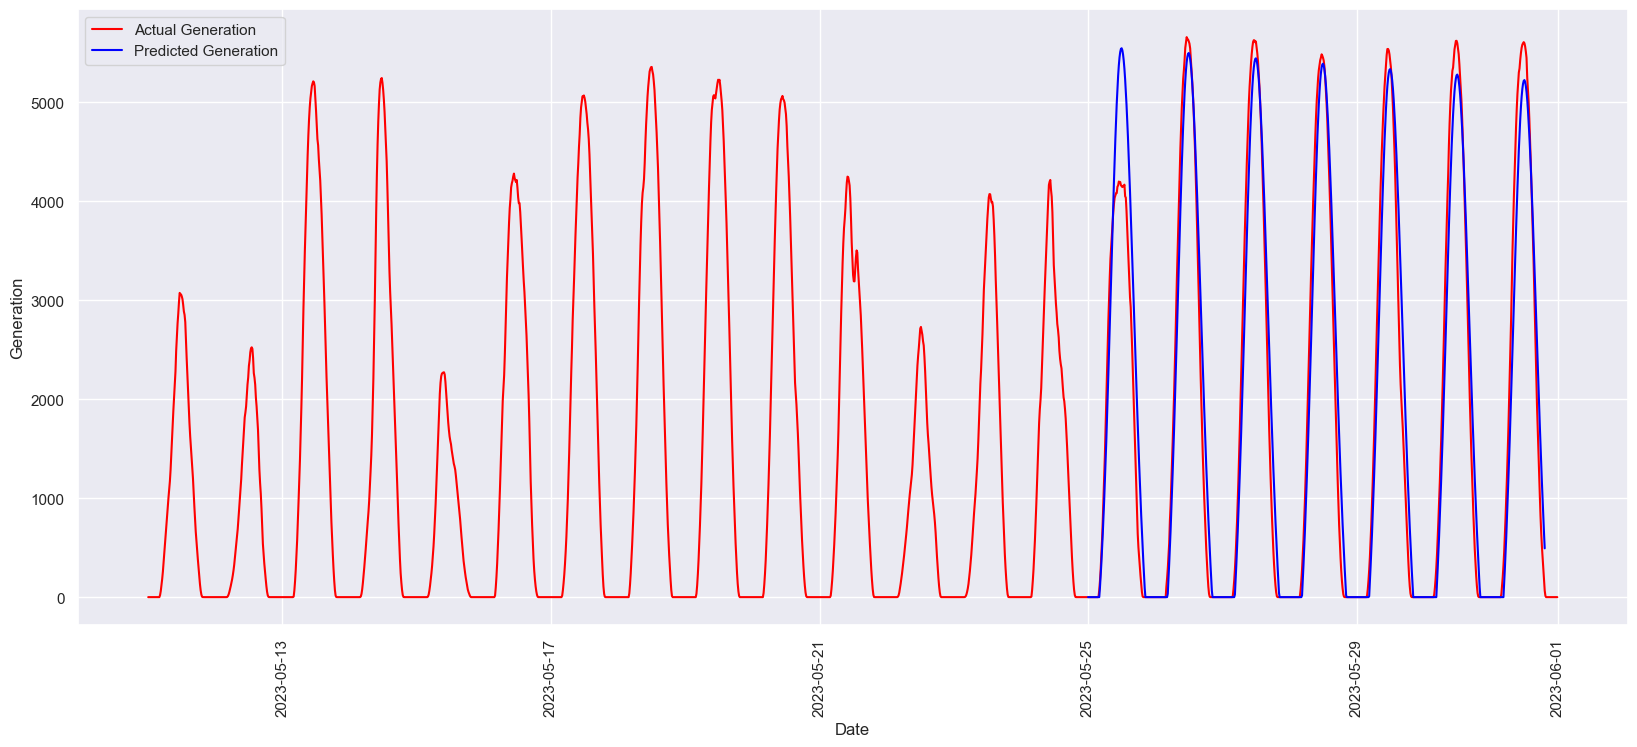

In [56]:
print(f'MSE\t{mean_absolute_error(df_tf_fwd.measured,predicted_values)}')
print(f'MSE\t{mean_squared_error(df_tf_fwd.measured,predicted_values)}')
print(f'R^2\t{r2_score(df_tf_fwd.measured,predicted_values)}')

plt.figure(figsize=(20,8))

sns.lineplot(data=df_tf_all.measured, label='Actual Generation', color='red')

predicted_values = np.maximum(predicted_values, 0)

shift_amount = -4.5
crop_amount = 18
scale = 1.5

predicted_index = pd.date_range(start=df_tf_bwd.index[-1] + pd.Timedelta(minutes=15) + pd.Timedelta(hours=shift_amount), periods=len(predicted_values), freq='15min')
predicted_values_cropped = scale*predicted_values[crop_amount:]
predicted_index_cropped = predicted_index[crop_amount:]

sns.lineplot(x=predicted_index_cropped, y=predicted_values_cropped.flatten(), label='Predicted Generation', color='blue')

# title = 'Belgium, history since 2019, 15m interval, 30d fwd'
plt.xlabel('Date')
# plt.xlim(pd.to_datetime('2019-01-01'), pd.to_datetime('2025-01-01'))
plt.ylabel('Generation')
plt.xticks(rotation=90)
# plt.title(title)
plt.show()

# plt.savefig(title)